# Lab 2: Localization of Wireless Cameras

### Important Notes:

-The xloc and yloc are all flipped in the data given to us

-Units are in inches.

-We need to localize 3 devices with the following MAC addresses:
    1. f8:cf:c5:97:e0:9e
    2. ec:d0:9f:db:e8:1f
    3. 80:e6:50:1b:a7:80
    4. Ground truth of device with MAC 44:91:60:d3:d6:94 is (-22, 162)
  Plan:
    1. We sort the all datasets into 4 sub-datasets for each MAC.
    2. The algorithm will use the log distance path loss model equation shown in detail in Lecture 7 Slides.
    3. Test the algorithm for the ground truth device.
    4. Extract location of other 3 devices.

In [1]:
import numpy as np, pandas as pd, json, os, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## 1. Take all datasets and sort them into 4 tables, one for each MAC address

In [2]:
cf = []
d0 = []
e6 = [] #initializaing empty arrays for each mac address
gt = [] #ground-truth device
with open('car_traces.txt','r') as f:
    files = list(filter(lambda x:x!='',f.read().split('\n')))
    fileind = {}
    for file in files:
        inds = file.split()
        if inds[0] in fileind:
            fileind[inds[0]].append(inds[1])
        else:
            fileind[inds[0]] = [inds[1]]
desiredfiles = fileind['eea7']
for file in desiredfiles: #takes data from every file in folder
    filename = os.fsdecode(file)
    path = 'final_lab2_data/' + filename
    with open(path, 'r') as f:
        data = (json.loads(f.read().replace('\'','\"')))
    for x in range(0, len(data)):
        entry = data[x]
        if entry['mac'] == 'f8:cf:c5:97:e0:9e':
            cf.append({'loc_x': entry['loc_y'], 'loc_y': entry['loc_x'], 'rss': entry['rss']})
        elif entry['mac'] == 'ec:d0:9f:db:e8:1f':
            d0.append({'loc_x': entry['loc_y'], 'loc_y': entry['loc_x'], 'rss': entry['rss']})
        elif entry['mac'] == '80:e6:50:1b:a7:80':
            e6.append({'loc_x': entry['loc_y'], 'loc_y': entry['loc_x'], 'rss': entry['rss']})
        elif entry['mac'] == '44:91:60:d3:d6:94':
            gt.append({'loc_x': entry['loc_y'], 'loc_y': entry['loc_x'], 'rss': entry['rss']})
cfdf = pd.DataFrame(cf).apply(pd.to_numeric)
d0df = pd.DataFrame(d0).apply(pd.to_numeric)
e6df = pd.DataFrame(e6).apply(pd.to_numeric)
gtdf = pd.DataFrame(gt).apply(pd.to_numeric)

## 2. Finding missing parameters of log-distance path loss model

The log-distance path loss equation:

$P_{RX}[dBm]=C-\gamma*log(d(TX,RX))$

We will take the ground truth access point and calculate distance at every point in its trace. Then, we have only two missing variables, $C$ and $\gamma$, which we can find via linear regression.

In [3]:
distances = (-1*np.log(((-22-gtdf.loc_x)**2+(162-gtdf.loc_y)**2)**.5)).values.reshape(-1,1)
reg = LinearRegression()
reg.fit(distances,gtdf.rss)
gamma = reg.coef_[0]
C = reg.intercept_
print("gamma: {}\nC: {}".format(gamma,C))

gamma: 5.547941048933078
C: -24.555201863547698


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


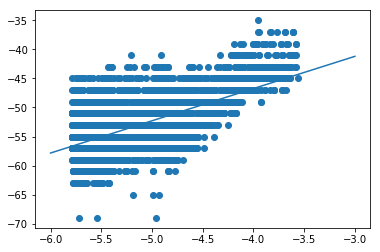

In [4]:
#plotting found regression against data
x = np.array(range(-6,-2))
plt.scatter(distances,gtdf.rss)
plt.plot(x,x*gamma+C)

## 3. FUCK

In [35]:
np.float_power(gtdf.rss.iloc[0],1/1.05)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in float_power
  """Entry point for launching an IPython kernel.


nan

In [33]:
optgam,optsum = 0,None
x1 = gtdf.loc_x.iloc[0]
y1 = gtdf.loc_y.iloc[0]
xj = gtdf.loc_x.iloc[1:]
yj = gtdf.loc_y.iloc[1:]
for i in np.arange(1,5.05,.05):
    gamma = i
    P1 = np.float_power(gtdf.rss.iloc[0],1/gamma)
    Pj = np.power(gtdf.rss.iloc[1:],1/gamma)
    #print(P1,Pj)
    A = np.array([2*(Pj**2*xj-P1**2*x1),2*(Pj**2*yj-P1**2*y1),P1**2-Pj**2]).transpose()
    b = np.array([Pj**2*(xj**2+yj**2)-P1**2*(x1**2+y1**2)]).transpose()
    #print(A,b)
    theta = np.matmul(np.linalg.inv(np.matmul(A.transpose(),A)),np.matmul(A.transpose(),b))
    #print(theta)
    d = ((theta[0][0]-gtdf.loc_x)**2+(theta[1][0]-gtdf.loc_y)**2)**.5
    print(d, ((theta[0][0]-gtdf.loc_x)**2+(theta[1][0]-gtdf.loc_y)**2))
    break
    d1, di = d.iloc[0], d.iloc[1:]
    #print(d1,di)
    tot = sum((d1/di-(Pj/P1))**2)
    if not optsum or (optsum and optsum > tot):
        optsum = tot
        optgam = gamma
    #print(tot)
print(optgam, optsum)

-57.0 1      -57.0
2      -57.0
3      -57.0
4      -57.0
5      -57.0
6      -55.0
7      -55.0
8      -53.0
9      -55.0
10     -55.0
11     -55.0
12     -55.0
13     -55.0
14     -55.0
15     -57.0
16     -59.0
17     -59.0
18     -59.0
19     -59.0
20     -55.0
21     -57.0
22     -61.0
23     -61.0
24     -57.0
25     -57.0
26     -59.0
27     -59.0
28     -51.0
29     -53.0
30     -51.0
        ... 
5311   -45.0
5312   -47.0
5313   -47.0
5314   -45.0
5315   -45.0
5316   -43.0
5317   -45.0
5318   -45.0
5319   -47.0
5320   -47.0
5321   -45.0
5322   -45.0
5323   -43.0
5324   -47.0
5325   -47.0
5326   -45.0
5327   -47.0
5328   -45.0
5329   -45.0
5330   -41.0
5331   -43.0
5332   -47.0
5333   -47.0
5334   -49.0
5335   -47.0
5336   -49.0
5337   -47.0
5338   -47.0
5339   -45.0
5340   -47.0
Name: rss, Length: 5340, dtype: float64
0       118.770099
1       118.768834
2       118.518821
3       118.517690
4       118.315486
5       118.314485
6       118.145738
7       118.145008
8       1

## 3. Finding locations of access points with our complete model

Reformatting the log-distance path loss equation to find $TX$:

$$\gamma*log(d(TX,RX)) = C-P_{RX}[dBm]$$

$$d(TX,RX) = e^{(C-P_{RX}[dBm])/\gamma}$$

Given d(TX,RX) for separate coordinates RX1 and RX2, we can use the two resultant equations to find TX, i.e.:

$$d(TX,RX1) = \sqrt{(x_{TX}-x_{RX1})^{2}+(y_{TX}-y_{RX1})^{2}}$$ 

$$d(TX,RX2) = \sqrt{(x_{TX}-x_{RX2})^{2}+(y_{TX}-y_{RX2})^{2}}$$

$$x_{TX}^{2}-2(x_{TX}*x_{RX1})+x_{RX1}^{2}+y_{TX}^{2}-2(y_{TX}*y_{RX1})+y_{RX1}^{2} = d(TX,RX1)^{2}$$

$$x_{TX}^{2}-2(x_{TX}*x_{RX2})+x_{RX2}^{2}+y_{TX}^{2}-2(y_{TX}*y_{RX2})+y_{RX2}^{2} = d(TX,RX2)^{2}$$

multiplying the first equation by $y_{RX2}/y_{RX1}$, subtracting the two equations and letting $const = \frac{y_{RX2}}{y_{RX1}}*(x_{RX1}^{2}+y_{RX1}^{2})-x_{RX2}^{2}-y_{RX2}^{2}$:

$$(\frac{y_{RX2}}{y_{RX1}}-1)*x_{TX}^{2}-2x_{TX}(\frac{y_{RX2}}{y_{RX1}}*x_{RX1}-x_{RX2})-\frac{y_{RX2}}{y_{RX1}}*d(TX,RX1)^{2}+d(TX,RX2)^{2}+const = 0$$

from which $x_{TX}$ can be solved by using the quadratic formula $x = \frac{-b \pm \sqrt{b^{2}-4ac}}{2a}$

where $a=(\frac{y_{RX2}}{y_{RX1}}-1)$, $b=-2(\frac{y_{RX2}}{y_{RX1}}*x_{RX1}-x_{RX2})$, and $c=-\frac{y_{RX2}}{y_{RX1}}*d(TX,RX1)^{2}+d(TX,RX2)^{2}+const$

Then we can find $y_{TX}$ by plugging $x_{TX}$ into $d(TX,RX1)$:

$$y_{TX} = \sqrt{d(TX,RX1)^{2}-(x_{TX}-x_{RX1})^{2}}+y_{RX1}$$


### testing for correctness with ground truth

In [5]:
ds = np.exp((C-gtdf.rss)/gamma)
ds.describe()

count    5341.000000
mean      240.608007
std       180.165313
min         6.570856
25%       117.518623
50%       241.672864
75%       346.568021
max      3014.061220
Name: rss, dtype: float64

In [6]:
gtdf.iloc[[0,270,-5000,-1550],:]

,loc_x,loc_y,rss
0,169.952433,261.000000,-57
270,50.104443,218.346221,-45
341,289.000000,207.736170,-57
3791,101.054759,21.000000,-59


In [7]:
ds.iloc[[10,2700,-11,-2701]]

10      241.672864
2700     81.949460
5330     19.377766
2640    496.991640
Name: rss, dtype: float64

In [8]:
x1, x2, y1, y2 = gtdf.loc_x.iloc[10], gtdf.loc_x.iloc[-11], gtdf.loc_y.iloc[10], gtdf.loc_y.iloc[-11]
x3, x4, y3, y4 = gtdf.loc_x.iloc[2700], gtdf.loc_x.iloc[-2701], gtdf.loc_y.iloc[2700], gtdf.loc_y.iloc[-2701]
d1, d2, d3, d4 = ds.iloc[10],ds.iloc[-11],ds.iloc[2700],ds.iloc[-2701]
a = np.array([[2*(x2-x1),2*(x4-x3)],[2*(y2-y1),2*(y4-y3)]])
b = np.array([d1**2-d2**2-x1**2+x2**2-y1**2+y2**2, d3**2-d4**2-x3**2+x4**2-y3**2+y4**2])
xt,yt = np.linalg.solve(a,b)
print("location of AP: ({},{})".format(xt,yt))

location of AP: (6288.691339727843,-21818.35741236306)


In [9]:
gtdf.head()

,loc_x,loc_y,rss
0,169.952433,261.0,-57
1,169.962440,261.0,-57
2,172.089242,261.0,-57
3,172.099658,261.0,-57
4,174.117874,261.0,-57


In [10]:
pd.DataFrame(data).head()

,loc_x,loc_y,mac,rss,time
0,165.0,117.515982,80:e6:50:1b:a7:80,-41,1.522977e+09
1,165.0,117.509990,80:e6:50:1b:a7:80,-41,1.522977e+09
2,165.0,117.503725,80:e6:50:1b:a7:80,-41,1.522977e+09
3,165.0,117.498012,80:e6:50:1b:a7:80,-41,1.522977e+09
4,165.0,117.479294,44:91:60:d3:d6:94,-53,1.522977e+09
